In [25]:
import json
with open("./data/hand-label/cardiomegaly-certain.json", "r") as read_file:
    data = json.load(read_file)

In [26]:
data

{'info': {'description': 'my-project-name'},
 'images': [{'id': 1,
   'width': 320,
   'height': 320,
   'file_name': 'patient00235_study1_view1_frontal.jpg'},
  {'id': 2,
   'width': 344,
   'height': 320,
   'file_name': 'patient00429_study1_view2_frontal.jpg'},
  {'id': 3,
   'width': 371,
   'height': 320,
   'file_name': 'patient00516_study1_view2_frontal.jpg'},
  {'id': 4,
   'width': 320,
   'height': 320,
   'file_name': 'patient00528_study3_view1_frontal.jpg'},
  {'id': 5,
   'width': 332,
   'height': 320,
   'file_name': 'patient00987_study2_view1_frontal.jpg'},
  {'id': 6,
   'width': 325,
   'height': 320,
   'file_name': 'patient01167_study48_view1_frontal.jpg'},
  {'id': 7,
   'width': 363,
   'height': 320,
   'file_name': 'patient02031_study1_view1_frontal.jpg'},
  {'id': 8,
   'width': 321,
   'height': 320,
   'file_name': 'patient02130_study1_view1_frontal.jpg'},
  {'id': 9,
   'width': 320,
   'height': 320,
   'file_name': 'patient02200_study2_view1_frontal.jpg'},

In [27]:
data['images']

[{'id': 1,
  'width': 320,
  'height': 320,
  'file_name': 'patient00235_study1_view1_frontal.jpg'},
 {'id': 2,
  'width': 344,
  'height': 320,
  'file_name': 'patient00429_study1_view2_frontal.jpg'},
 {'id': 3,
  'width': 371,
  'height': 320,
  'file_name': 'patient00516_study1_view2_frontal.jpg'},
 {'id': 4,
  'width': 320,
  'height': 320,
  'file_name': 'patient00528_study3_view1_frontal.jpg'},
 {'id': 5,
  'width': 332,
  'height': 320,
  'file_name': 'patient00987_study2_view1_frontal.jpg'},
 {'id': 6,
  'width': 325,
  'height': 320,
  'file_name': 'patient01167_study48_view1_frontal.jpg'},
 {'id': 7,
  'width': 363,
  'height': 320,
  'file_name': 'patient02031_study1_view1_frontal.jpg'},
 {'id': 8,
  'width': 321,
  'height': 320,
  'file_name': 'patient02130_study1_view1_frontal.jpg'},
 {'id': 9,
  'width': 320,
  'height': 320,
  'file_name': 'patient02200_study2_view1_frontal.jpg'},
 {'id': 10,
  'width': 371,
  'height': 320,
  'file_name': 'patient02258_study3_view1_fro

In [ ]:
class CheXpertHeartDataset(Dataset):
    def __init__(self, data_dir, image_dir, transforms=None):
        super().__init__()

        self.labels_paths = os.listdir(data_dir)
        self.paths = [s.replace('_', '/', 2) for s in os.listdir(data_dir)]
        self.paths = [s.replace('.txt', '.jpg') for s in self.paths]
        self.data_dir = data_dir
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        label_path = self.labels_paths[idx]
        print(f'{self.image_dir}/{image_path}')
        image = cv2.imread(f'{self.image_dir}/{image_path}', 0)
        image = cv2.merge([image, image, image])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        labels = pd.read_csv(self.data_dir + '/' + label_path, header=None, delimiter=" ",
                             names=['clazz', 'x_min', 'y_min', 'x_max', 'y_max'])

        labels = labels[labels.clazz.eq(0)]

        height, width, _ = image.shape
        x, y, w, h = labels[['x_min', 'y_min', 'x_max', 'y_max']].values[0]

        boxes = torch.as_tensor(
            np.array([[(x - (w / 2)) * width, (y - (h / 2)) * height, (x + (w / 2)) * width, (y + (h / 2)) * height]]),
            dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.squeeze(torch.as_tensor((labels.clazz.values,), dtype=torch.int64)) + 1

        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.paths)

In [10]:
data['images'][0]

{'id': 1,
 'width': 320,
 'height': 320,
 'file_name': 'patient00235_study1_view1_frontal.jpg'}

In [3]:
from utils.utils import annotation2binarymask

In [4]:
idx = 0

In [5]:
image_data, annotation = data['images'][idx], data['annotations'][idx]

0 patient29379_study1_view1_frontal.jpg
(320, 369)


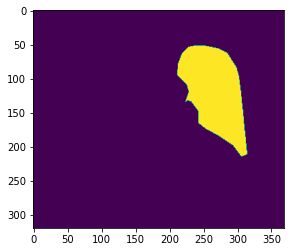

In [30]:
import numpy as np
import cv2
from matplotlib.pyplot import imshow

for idx, d in enumerate(data['images'][179:180]):
    w,h = d['width'], d['height']
    print(idx, d['file_name'])
    annotations = [x for x in data['annotations'] if x['image_id'] == d['id']]
    mask = annotation2binarymask(annotations,h,w)
    print(mask.shape)
    imshow(mask)

In [65]:
import json
from torch.utils.data import DataLoader, Dataset
from datasets.lungdatasets import MEAN,STD
import albumentations as A
import torch

def get_transforms(size, test = False):
    #TODO: Do test-time augmentation?
    return A.Compose([
        A.Resize(height=size, width=size, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=45, p=0.3),
    ])


class CheXpertLungSegmentationDataset(Dataset):
    def __init__(self, data_dir, image_dir, aug_transform, mean=MEAN,std=STD):
        with open(data_dir, "r") as read_file:
            self.data = json.load(read_file)
    
        self.image_dir = image_dir
        self.data_dir = data_dir
        self.aug_transform = aug_transform
        self.norm_transform = A.Normalize(mean=mean, std=std)

    def __getitem__(self, idx):
        whole_data = self.data['images']
        d = whole_data[idx]
        w,h = d['width'], d['height']
        annotations = [x for x in data['annotations'] if x['image_id'] == d['id']]
        mask = annotation2binarymask(annotations,h,w)
        print(mask.shape)
        print(d['file_name'])
        img_path = self.image_dir + d['file_name'].replace('_','/', 2)
        print(img_path)
        img = cv2.imread(img_path)
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        augmented = self.aug_transform(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        img = self.norm_transform(image=img)["image"]
        return torch.FloatTensor(img), torch.FloatTensor(mask)

    def __len__(self):
        return len(self.data['images'])

In [66]:
ds = CheXpertLungSegmentationDataset("./data/hand-label/cardiomegaly-certain.json", '../CheXpert-v1.0-small/train/', aug_transform=get_transforms(320))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 320)
patient00235_study1_view1_frontal.jpg
../CheXpert-v1.0-small/train/patient00235/study1/view1_frontal.jpg
(320, 320, 3)


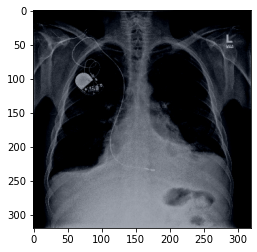

In [72]:
imshow((ds[0][0] + MEAN)*STD)

(320, 320)
patient00235_study1_view1_frontal.jpg
../CheXpert-v1.0-small/train/patient00235/study1/view1_frontal.jpg
(320, 320, 3)


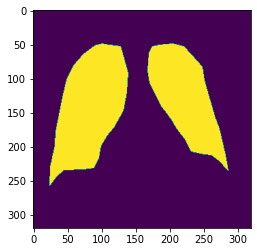

In [68]:
imshow(ds[0][1])

In [ ]:
class SchenzenMontgomeryLungSegmentationDataset(Dataset):
    def __init__(self, df, data_dir, aug_transform, test=False, mean=MEAN,std=STD):
        self.df = df
        self.data_dir = data_dir
        self.test = test
        self.aug_transform = aug_transform
        self.norm_transform = A.Normalize(mean=mean, std=std)

    def __getitem__(self, idx):
        if self.test:
            img_path = self.data_dir + 'data/test/' + self.df.iloc[idx, 0] + ".png"
        else:
            img_path = self.data_dir + 'data/CXR_png/' + self.df.iloc[idx, 0] + ".png"

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.test:
            augmented = self.aug_transform(image=img)
            img = augmented['image']
            img = self.norm_transform(image=img)["image"]
            return torch.FloatTensor(img)
        else:
            ending = '_mask.png' if self.df.iloc[idx, 0].startswith('CHN') else '.png'
            mask_path = self.data_dir + 'data/masks/' + self.df.iloc[idx, 0] + ending
            mask = cv2.imread(mask_path)[:, :, 0]
            mask = np.clip(mask, 0, 1).astype("float32")

            augmented = self.aug_transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            img = self.norm_transform(image=img)["image"]
            return torch.FloatTensor(img), torch.FloatTensor(mask)

    def __len__(self):
        return len(self.df)